In [ ]:
# Training NN with Elegy then do HMC 
# Author: Peter Oct 24 2021
# Requirements: 
#!module load system/CUDA/11.0.2 
#!pip install --upgrade jax jaxlib==0.1.68+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html 
#!pip install tensorflow-io oryx elegy

from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.10'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
from jax import jit
from jax import grad

assert jax.default_backend() == 'gpu'

import elegy # pip install elegy
import optax
#import flax.linen
import tensorflow_io as tfio # pip install tensorflow-io
import tensorflow as tf # Recommended not to import this with jax because will also try to grab memory.

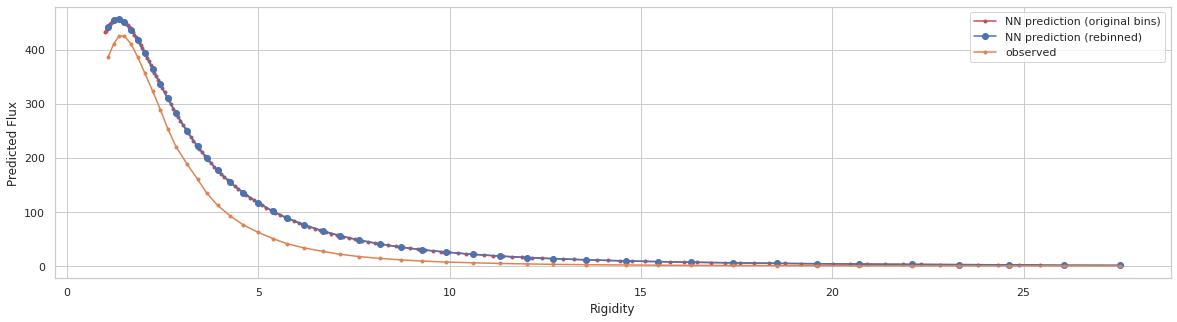

In [20]:
# Check shape of the output.
import importlib
import gcr_utils
importlib.reload(gcr_utils)

model_path = 'model_2_256_selu_l21e-6' # 'model_2_256_tanh' #'model_2_256_selu_l21e-6_do_aug' #'model_2_256_selu_l21e-6' #'model_2_256_selu' #'model_debug' #'model_2_256_tanh'
nn = gcr_utils.define_nn_pred(model_path=model_path, normalize_input_flag=True, denormalize_output_flag=True, rebin_output_flag=False)
xloc, iloc, observed, uncertainty, alpha, cmf = gcr_utils.load_preprocessed_data_ams()

x = np.array([69.19, 5.17, 90, .5, 1.7, 1.4, 1.1 ]) 
yhat = nn(x)
yhat_rebin = gcr_utils.rebin_output(yhat)

# Interpolate to get predicted flux at both lattice and bin points.
plt.figure(1, figsize=(20,5))
plt.plot(gcr_utils.RIGIDITY_VALS[:150], yhat[:150], label='NN prediction (original bins)', marker='.', color='r')
bin_midpoints = (xloc[iloc][:-1] + xloc[iloc][1:]) / 2
plt.plot(bin_midpoints, yhat_rebin,  label='NN prediction (rebinned)', marker='o') # Matches original bins.
plt.plot(bin_midpoints, observed,  label='observed', marker='.')

#plt.scatter(x=xloc.to_py()[iloc], y=yloc.to_py()[iloc], label='Bin edges')
plt.xlabel('Rigidity')
plt.ylabel('Predicted Flux')
plt.legend()

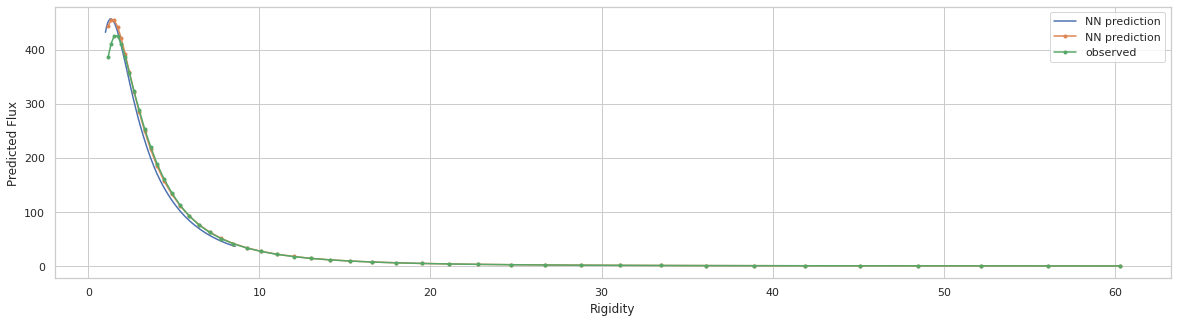

In [54]:
# 
    
import importlib
import gcr_utils
importlib.reload(gcr_utils)

model_path = 'model_2_256_selu_l21e-6' #'model_2_256_selu' #'model_debug' #'model_2_256_tanh'
nn = gcr_utils.define_nn_pred(model_path=model_path, normalize_input_flag=True, denormalize_output_flag=True, rebin_output_flag=False)
xloc, iloc, observed, uncertainty, alpha, cmf = gcr_utils.load_preprocessed_data_ams()

x = np.array([69.19, 5.17, 90, .5, 1.7, 1.4, 1.1 ]) 
yhat = nn(x)
#yhat_rebin = gcr_utils.rebin_output(yhat)

# Interpolate to get predicted flux at both lattice and bin points.
yloc = jnp.interp(xloc, gcr_utils.RIGIDITY_VALS, yhat) 
# Integrate over bin regions, and compare to observed to get likelihood.
chi2 = 0.0
yhat_rebin = np.zeros(45)
for i in range(45):
    # Integrate over bin by trapezoid method.
    istart, istop = iloc[i], iloc[i+1]
    area = jnp.trapz(y=yloc[istart:(istop+1)], x=xloc[istart:(istop+1)])
    length = (xloc[istop] - xloc[istart])
    predicted = area / length
    yhat_rebin[i] = predicted
    chi2 += ((predicted - observed[i])/uncertainty[i])**2

# Interpolate to get predicted flux at both lattice and bin points.
plt.figure(i, figsize=(20,5))
plt.plot(gcr_utils.RIGIDITY_VALS[:100], yhat[:100], label='NN prediction')
plt.plot(xloc[iloc][1:], yhat_rebin,  label='NN prediction', marker='.')
plt.plot(xloc[iloc][1:], observed,  label='observed', marker='.')

#plt.scatter(x=xloc.to_py()[iloc], y=yloc.to_py()[iloc], label='Bin edges')
plt.xlabel('Rigidity')
plt.ylabel('Predicted Flux')
plt.legend()

In [ ]:
# Check training data.
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
#x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
x = tfio.IODataset.from_hdf5(f, dataset='/X')
y = tfio.IODataset.from_hdf5(f, dataset='/Y') #Y_logp1_scaled
train = tf.data.Dataset.zip((x, y)).take(128)

for i,(x,y) in enumerate(train):
    if i>3:
        break
    x, y =  x.numpy(), y.numpy()